#### Explainability of BiLSTM using Attention

In [1]:
from operator import index

import torch

import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = 'cpu'

In [3]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [4]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [5]:
# Load the trained BiLSTM model
from models.bilstm import BiLSTMSpam

model_path = DATA_PATH + '/trained-models/spam_bilstm_final.pt'
model = BiLSTMSpam(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                   pretrained_embeddings=pretrained_embeddings)
model.load(model_path, map_location=torch.device('cpu'))
model = model.to(device)
model.eval()

BiLSTMSpam(
  (embedding): Embedding(25245, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
from utils.functions import encode

# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [7]:
# Get model predictions
with torch.no_grad():
    model_output = model(X_test_tensor)
    # If model returns a tuple, use the first element (typically the predictions)
    if isinstance(model_output, tuple):
        y_pred_probs = model_output[0]
    else:
        y_pred_probs = model_output

    y_pred = (y_pred_probs > 0.5).float()

In [8]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


#### BiLSTM Explanation Quality Metrics Using LIME

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0



Explaining easy_ham email: Seeing is believing


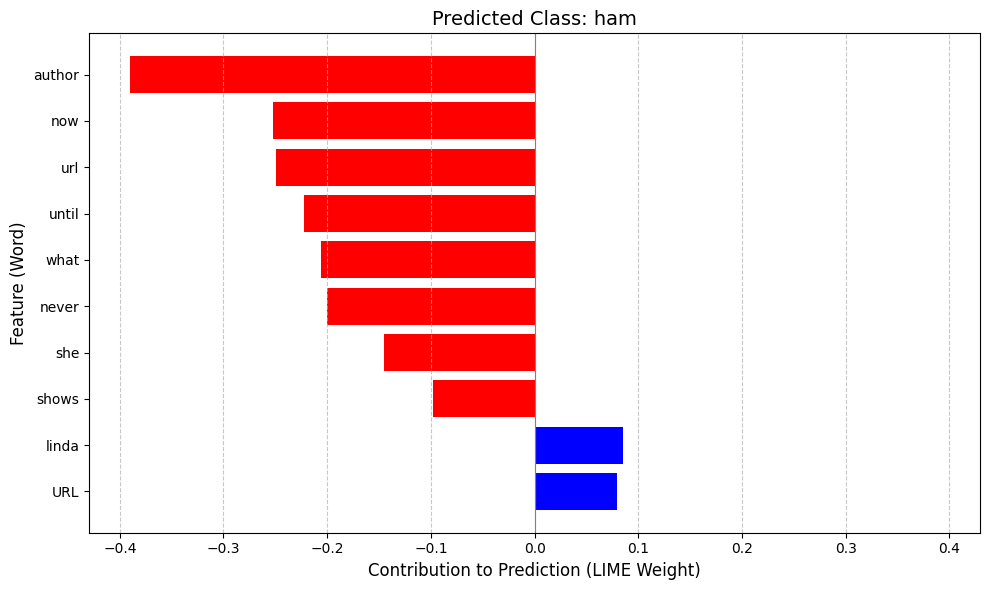


Explaining hard_ham email: Apple Store eNews : November 2002


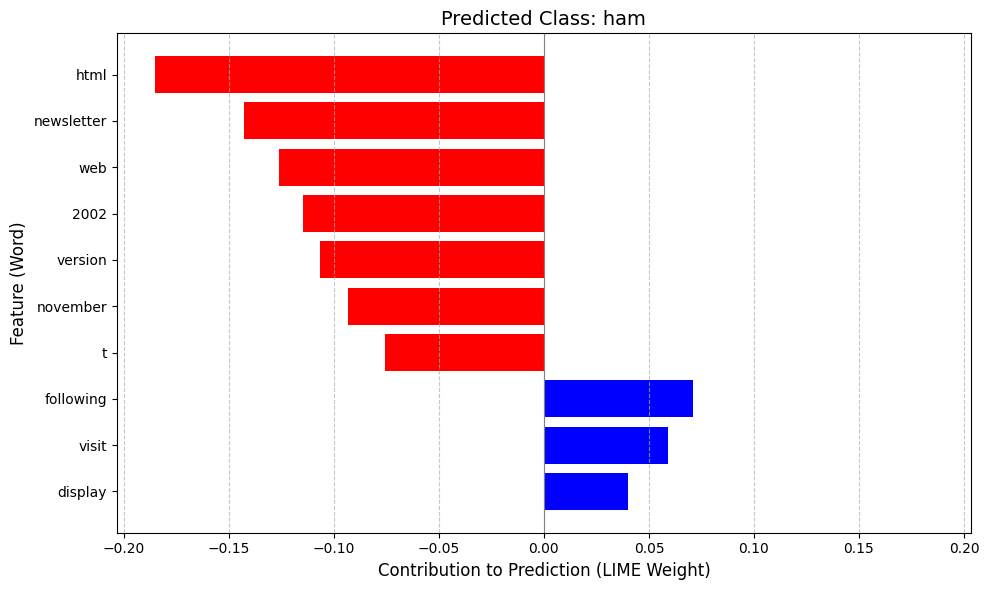


Explaining easy_ham_2 email: RE: [ILUG] NVIDIA and Debian Woody


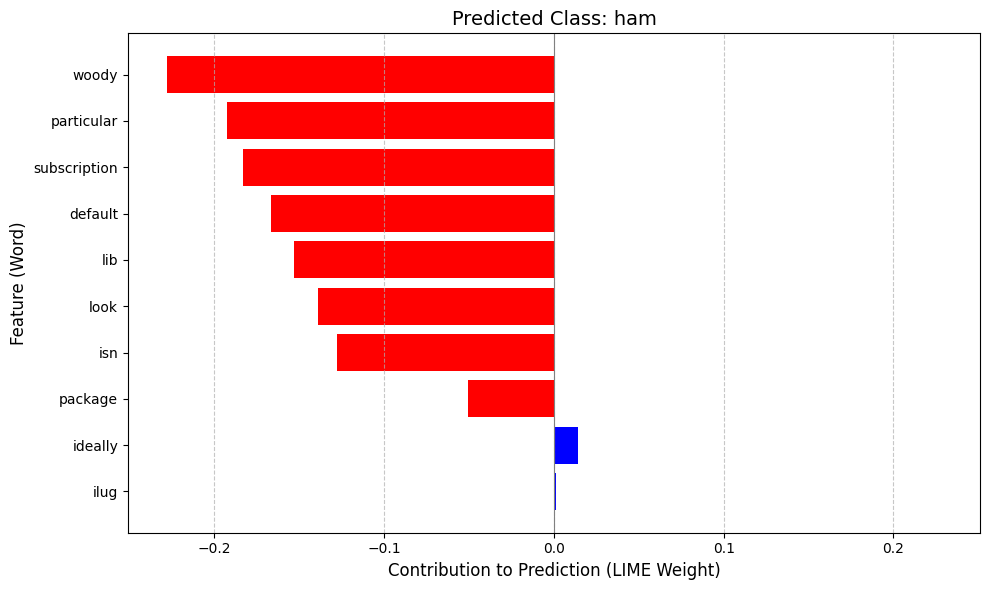


Explaining spam email: The Flight to Safety is Upon Us


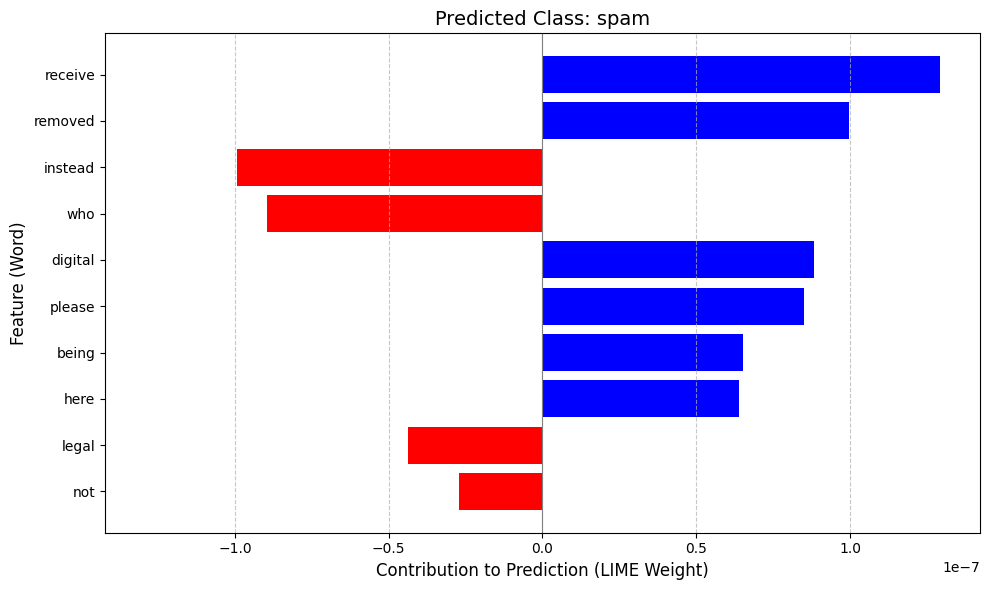


Explaining spam email: Low cost quality conference calls


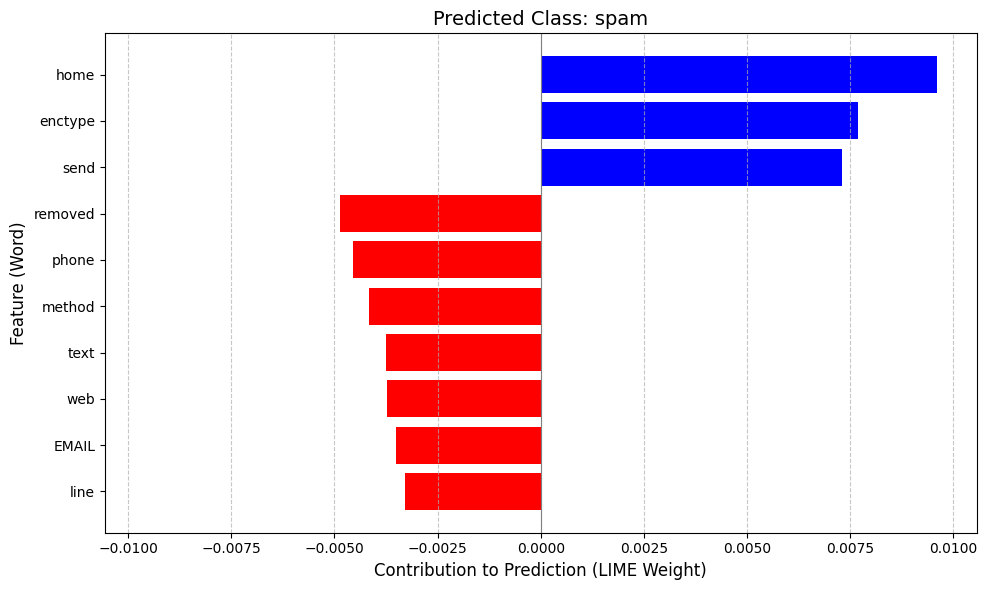


Explaining spam_2 email: Cannabis Difference


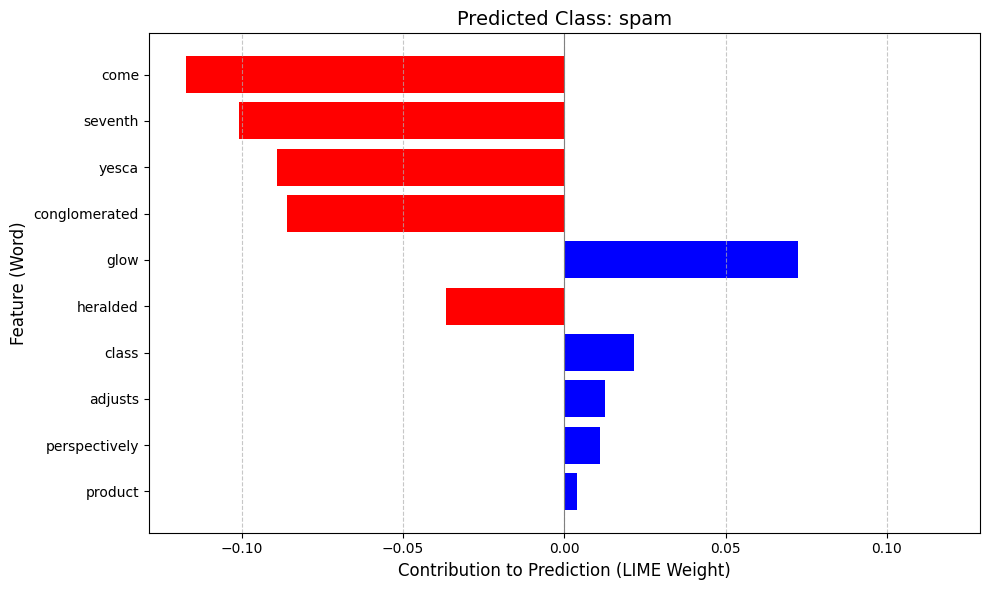

In [9]:
import numpy as np
from explainability.BiLSTMLimeExplainer import get_lime_explanation, plot_lime_explanation

class_names = ['ham', 'spam']
for i in samples:
    print(f"\nExplaining {test_df['source'].iloc[i]} email: {test_df['subject'].iloc[i]}")
    explanation = get_lime_explanation(
        model,
        test_df['text'].iloc[i],
        word2idx,
        idx2word,
        num_samples=500,
        alpha=0.01
    )

    plot_lime_explanation(explanation.as_list(), f"Predicted Class: {class_names[np.argmax(explanation.predict_proba)]}")



Computing metrics for sample 150: Seeing is believing
Plotting deletion and insertion curves for sample 150


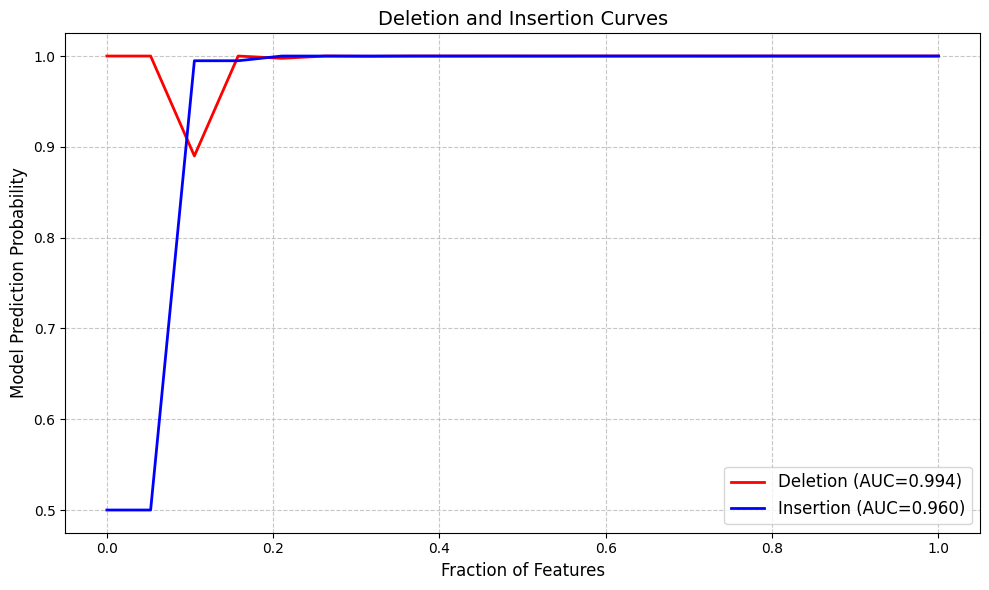


Computing metrics for sample 357: Apple Store eNews : November 2002
Plotting deletion and insertion curves for sample 357


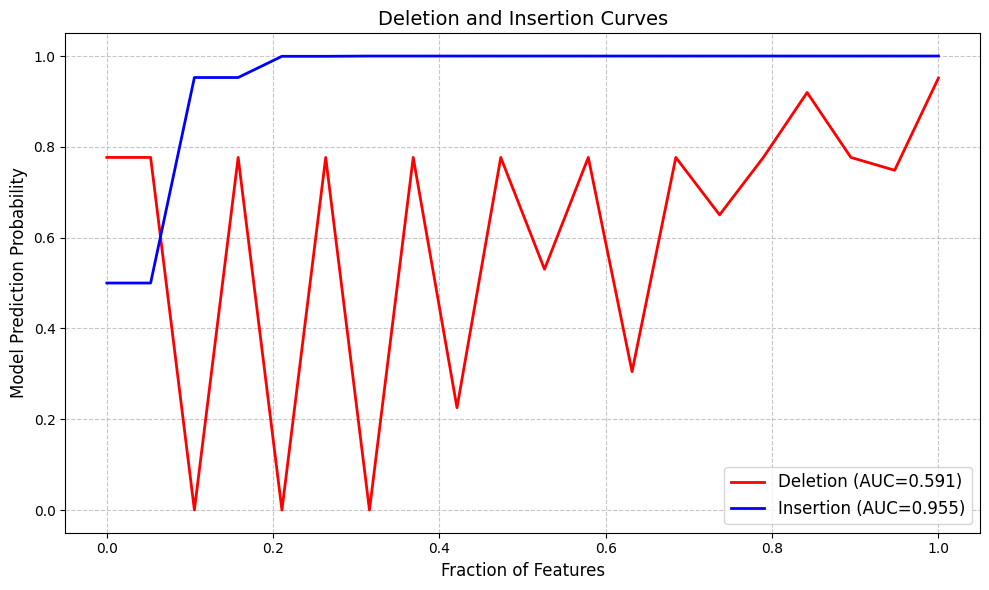


Computing metrics for sample 402: RE: [ILUG] NVIDIA and Debian Woody
Plotting deletion and insertion curves for sample 402


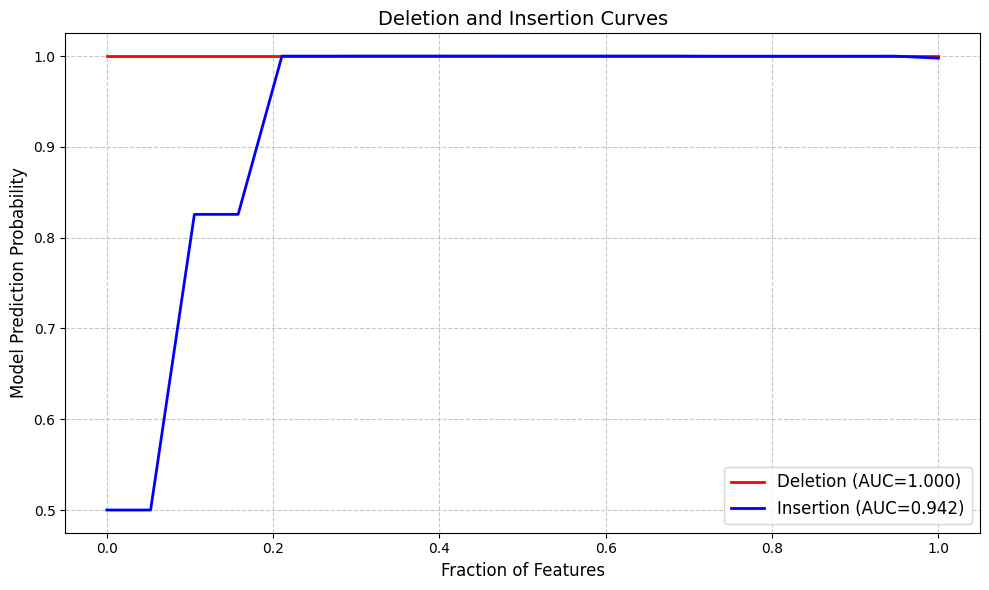


Computing metrics for sample 416: The Flight to Safety is Upon Us
Plotting deletion and insertion curves for sample 416


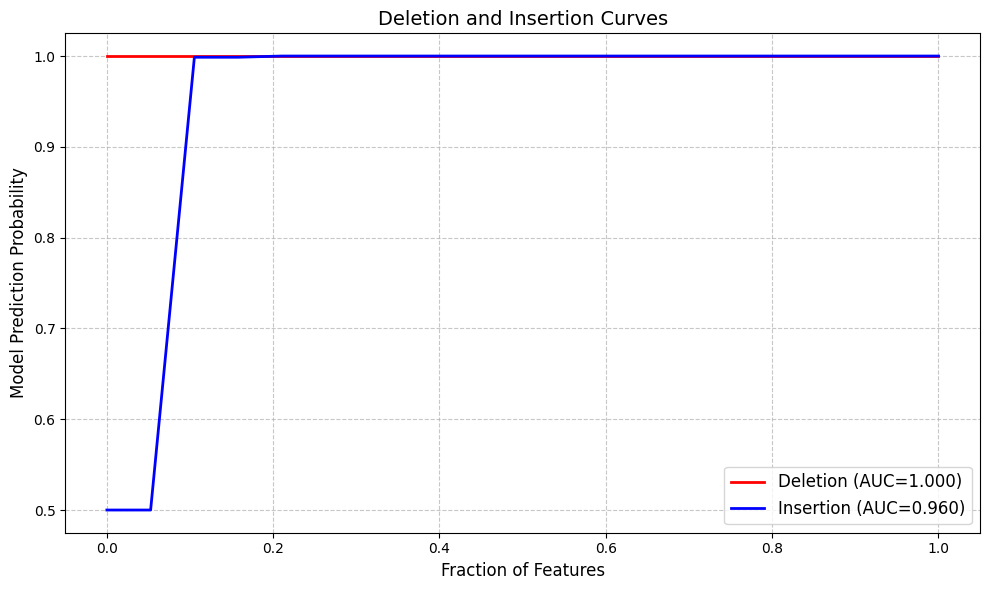


Computing metrics for sample 417: Low cost quality conference calls
Plotting deletion and insertion curves for sample 417


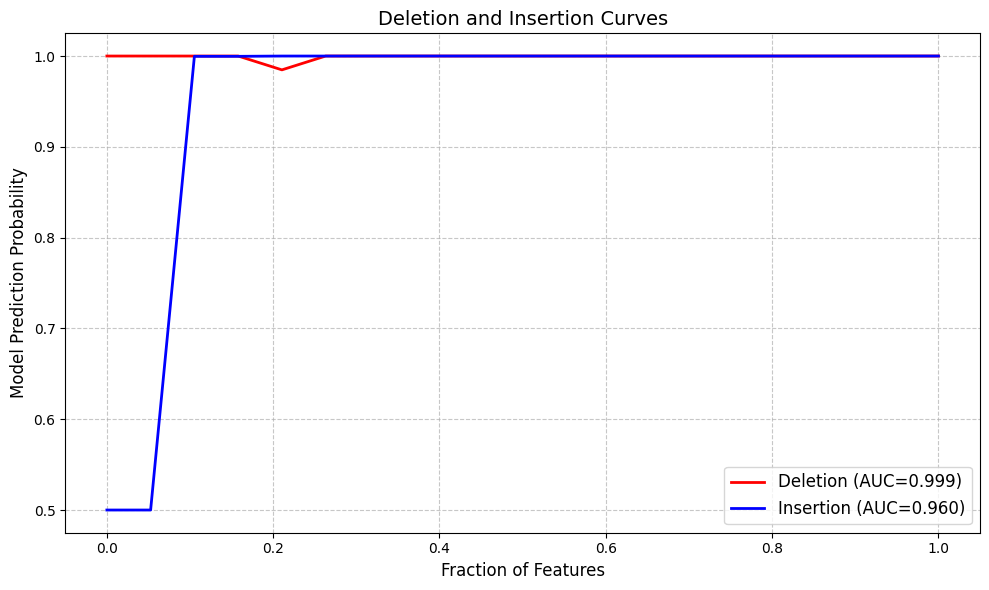


Computing metrics for sample 604: Cannabis Difference
Plotting deletion and insertion curves for sample 604


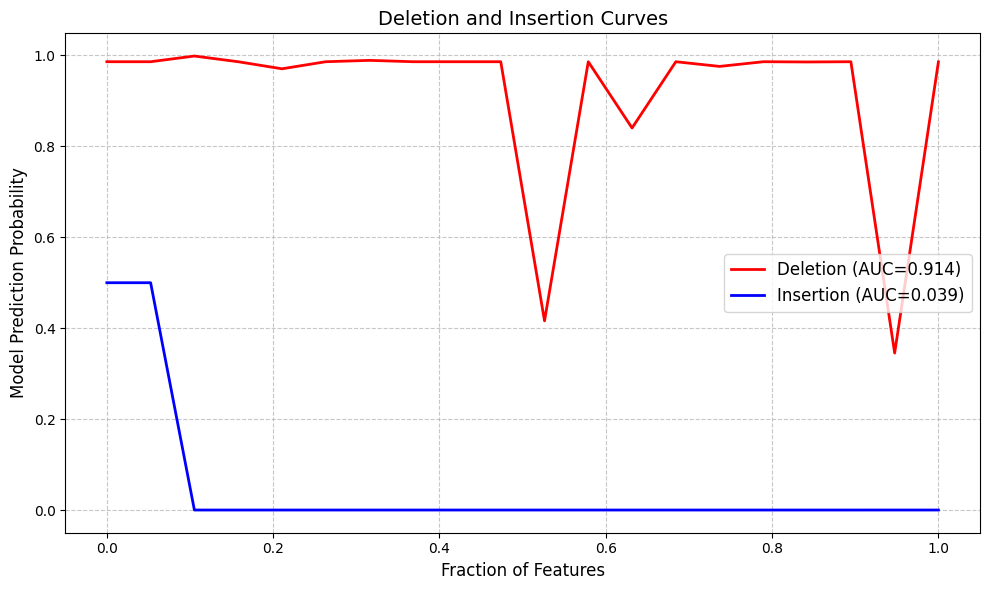

In [10]:
from explainability.BiLSTMLimeExplainer import (
    compute_auc_deletion, compute_auc_insertion, compute_comprehensiveness,
    compute_jaccard_stability, plot_deletion_insertion_curves, plot_metrics_across_samples,
    BiLSTMLimeExplainer, get_lime_explanation
)
# Create the wrapper for model predictions
explainer_wrapper = BiLSTMLimeExplainer(
    model,
    word2idx,
    idx2word,
    str(device)
)

# Let's calculate metrics for each sample and store them
metrics_results = []

for i in samples:
    print(f"\nComputing metrics for sample {i}: {test_df['subject'].iloc[i]}")

    explanation = get_lime_explanation(
        model,
        test_df['text'].iloc[i],
        word2idx,
        idx2word,
        num_samples=500,
        alpha=0.01
    )

    # Text to explain
    text = test_df['text'].iloc[i]

    # Calculate metrics
    auc_del = compute_auc_deletion(explainer_wrapper, explanation, text)
    auc_ins = compute_auc_insertion(explainer_wrapper, explanation, text)
    comprehensiveness = compute_comprehensiveness(explainer_wrapper, explanation, text, k=5)

    # For Jaccard stability, we need similar inputs
    # For text, this is tricky - we'll use a simple approach of taking the current sample
    # and creating variations by removing random words
    # This is a very simplistic approach - in practice, you might want to use
    # techniques like synonym replacement, word dropout, etc.

    # Create slightly modified versions of the text
    import random
    random.seed(42)  # For reproducibility
    tokens = text.split()
    similar_texts = [text]  # Include the original text

    # Create 3 variations by removing 10% of words randomly
    for _ in range(3):
        num_to_remove = max(1, int(len(tokens) * 0.1))
        indices_to_remove = random.sample(range(len(tokens)), num_to_remove)
        modified_tokens = [tokens[i] for i in range(len(tokens)) if i not in indices_to_remove]
        similar_texts.append(' '.join(modified_tokens))

    stability = compute_jaccard_stability(
        model,
        similar_texts,
        word2idx,
        idx2word,
        num_features=5
    )

    metrics_results.append({
        'Sample': i,
        'Subject': test_df['subject'].iloc[i],
        'AUC-Del': auc_del,
        'AUC-Ins': auc_ins,
        'Comprehensiveness': comprehensiveness,
        'Jaccard Stability': stability
    })

    # Plot deletion and insertion curves for this sample
    print(f"Plotting deletion and insertion curves for sample {i}")
    plot_deletion_insertion_curves(explainer_wrapper, explanation, text)

# Create a DataFrame from the metrics results
metrics_df = pd.DataFrame(metrics_results)
metrics_df.set_index('Sample', inplace=True)

In [11]:
metrics_df

,Subject,AUC-Del,AUC-Ins,Comprehensiveness,Jaccard Stability
Sample,,,,,
150,Seeing is believing,0.994051,0.959980,9.999944e-01,0.478175
357,Apple Store eNews : November 2002,0.591211,0.955479,7.766701e-01,0.309524
402,RE: [ILUG] NVIDIA and Debian Woody,1.000000,0.942054,0.000000e+00,0.000000
416,The Flight to Safety is Upon Us,1.000000,0.960387,2.384186e-07,0.162037
417,Low cost quality conference calls,0.999198,0.960491,5.973641e-01,0.157407
604,Cannabis Difference,0.914180,0.039478,4.244393e-02,0.037037
